## ⏬ **Import Modules & Set Up Environment**

*Importing necessary libraries for data manipulation and visualization*

In [1]:
# Standard Libraries
import pandas as pd  # Data manipulation
import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # Data visualization
import joblib  # Model saving/loading

# Scikit-learn: Data Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV  # Data splitting and hyperparameter tuning
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # Feature scaling and encoding
from sklearn.impute import SimpleImputer  # Handling missing data
from sklearn.compose import ColumnTransformer  # Column-specific transformations
from sklearn.pipeline import Pipeline  # Streamlining preprocessing and modeling

# Scikit-learn: Model Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report  # Regression and classification metrics

# XGBoost
from xgboost import XGBRegressor  # XGBoost regression model


*Setting up interactive environment*

In [2]:
# IPython functionality for interactive environments
from IPython.core.interactiveshell import InteractiveShell  # Controls interactive shell behavior

# Setting IPython display option to show all outputs in a single cell
# This ensures that all outputs from the cell are displayed, not just the result of the last line.
InteractiveShell.ast_node_interactivity = "all"


## 📂 **Load Dataset**

In [3]:
# Read data
df = pd.read_csv("../data/final_car_data.csv")

# Convert 'Number_of_Owners' to object type (string)
df['Number_of_Owners'] = df['Number_of_Owners'].astype('object')

# View information
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2494 entries, 0 to 2493
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Brand             2494 non-null   object
 1   Type              2494 non-null   object
 2   Reg_year          2494 non-null   int64 
 3   Coe_left          2494 non-null   int64 
 4   Depreciation      2494 non-null   int64 
 5   Mileage           2494 non-null   int64 
 6   Dereg_Value       2494 non-null   int64 
 7   COE               2494 non-null   int64 
 8   Engine_Capacity   2494 non-null   int64 
 9   Curb_Weight       2494 non-null   int64 
 10  Manufactured      2494 non-null   int64 
 11  Transmission      2494 non-null   object
 12  OMV               2494 non-null   int64 
 13  Power             2494 non-null   int64 
 14  Number_of_Owners  2494 non-null   object
 15  Price             2494 non-null   int64 
dtypes: int64(12), object(4)
memory usage: 311.9+ KB


## 🛠️ **Preprocess Data**
- `Handles Missing Values`: Ensures the dataset is complete by filling or removing missing data.
- `Standardizes Scales`: Normalizes numeric features to a common scale, improving model performance.
- `Encodes Categorical Variables`: Converts categorical data into numeric format for machine learning algorithms.
- `Improves Model Accuracy`: Clean, well-structured data leads to better model training and predictions.
- `Reduces Bias`: Ensures no single feature dominates due to differences in scale or format.
- `Prepares for Model Compatibility`: Makes the data suitable for algorithms that require specific input formats.

### 🛠️ **Step 1: Separate features (X) and target variable (y)**
- `X`: Features (independent variables), created by dropping the target column 'Price' from the dataset.
- `y`: Target variable (dependent variable), which is the column 'Price' from the dataset.

In [4]:
# Separate features (X) and target (y)
X = df.drop('Price', axis=1) 
y = df['Price']  

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns  
categorical_features = X.select_dtypes(include=['object']).columns  

# Show the numeric and categorical columns as arrays
print("\n🔢 Numeric Features:")
print(numeric_features.tolist()) 
print("\n📊 Categorical Features:")
print(categorical_features.tolist()) 



🔢 Numeric Features:
['Reg_year', 'Coe_left', 'Depreciation', 'Mileage', 'Dereg_Value', 'COE', 'Engine_Capacity', 'Curb_Weight', 'Manufactured', 'OMV', 'Power']

📊 Categorical Features:
['Brand', 'Type', 'Transmission', 'Number_of_Owners']


### 🛠️ **Step 2: Preprocess features (X) and target variable (y)**
- `X`: Features (all columns except 'Price') are preprocessed:
    - Numeric features: Impute missing values with the median and scale using StandardScaler.
    - Categorical features: Impute missing values with the mode and one-hot encode.
- `y`: Target variable ('Price') is separated for model training.

In [5]:
# Define numeric feature preprocessing: impute missing values and scale
# - Impute missing values with the median (robust to outliers)
# - Scale numeric features to have zero mean and unit variance (important for gradient-based models like XGBoost)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute with median
    ('scaler', StandardScaler())  # Standardize numeric features
])

# Define categorical feature preprocessing: impute missing values and one-hot encode
# - Impute missing values with the most frequent value (mode)
# - One-hot encode categorical variables to convert them into numeric format (required for XGBoost)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute with mode
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode (ignore unknown categories in test data)
])

# Combine numeric and categorical preprocessing into a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),  # Apply numeric transformer to numeric columns
        ('cat', categorical_transformer, categorical_features)  # Apply categorical transformer to categorical columns
    ])


### 🛠️ **Step 3: Split Data into Training and Testing Sets**
- Split the data into 80% training and 20% testing:
    - `test_size=0.2`: 20% of the data is reserved for testing.
    - `random_state=42`: Ensures the split is reproducible.

In [6]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 📦 **Select Model and Build Pipeline**
Why Choose XGBoost?
- `High Performance`: Consistently delivers state-of-the-art results in predictive accuracy.
- `Handles Missing Values`: Automatically manages missing data during training.
- `Feature Importance`: Provides insights into which features contribute most to predictions.
- `Scalability`: Efficiently handles large datasets and high-dimensional data.
- `Regularization`: Built-in L1 and L2 regularization to prevent overfitting.
- `Flexibility`: Supports regression, classification, and ranking tasks.
- `Speed`: Optimized for fast training and prediction, even on large datasets.
- `Cross-Validation`: Includes built-in support for cross-validation during training.

In [7]:
# Initialize XGBoost regressor
# - objective: 'reg:squarederror' for regression
# - random_state: Ensures reproducibility
# - n_estimators: Number of trees (boosting rounds)
# - learning_rate: Controls step size to prevent overfitting
regressor = XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100, learning_rate=0.1)

# Create pipeline: preprocess data and train model
# - preprocessor: Handles missing values, scaling, and encoding
# - regressor: Trains XGBoost model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing step
    ('regressor', regressor)  # Model training step
])


## 🔧 **Tune Hyperparameters**
- `Optimizes Model Performance`: Finds the best combination of hyperparameters to maximize model accuracy and efficiency.
- `Increases Model Robustness`: Fine-tunes model settings to make the algorithm generalize better on unseen data.
- `Enhances Predictive Power`: Adjusts learning rate, depth, and other parameters to improve the model's prediction capability.
- `Reduces Overfitting/Underfitting`: Ensures the model is not too complex or too simple, avoiding both overfitting and underfitting.
- `Improves Efficiency`: Fine-tuning can help reduce computation time while maintaining or increasing model performance.
- `Provides Better Model Insights`: By testing a range of hyperparameters, we can identify the most influential factors for model success.

In [8]:
# Define the parameter grid
# 'regressor__n_estimators': Number of boosting rounds (trees); higher values may improve model but increase computation time
# 'regressor__learning_rate': Step size at each iteration; smaller values make the model more robust but slower to converge
# 'regressor__max_depth': Maximum depth of each tree; higher values allow more complex models, but might lead to overfitting
param_grid = {
    'regressor__n_estimators': [50, 100, 200, 500],  
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7, 9] 
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    model_pipeline,  # Model pipeline to tune
    param_grid,  # Hyperparameter grid to search
    cv=5,  # 5-fold cross-validation for better model evaluation
    scoring='neg_root_mean_squared_error',  # Use negative RMSE as scoring metric
    n_jobs=-1,  # Use all available CPUs for parallel processing
    verbose=3  # Display detailed output during the search
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and corresponding RMSE
best_params = grid_search.best_params_
best_rmse = -grid_search.best_score_
print("\n⭐ Best Hyperparameters:")
print(best_params)
print("\n⭐ Best RMSE")
print(best_rmse)


Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Reg_year', 'Coe_left', 'Depreciation', 'Mileage', 'Dereg_Value', 'COE',
       'Engine_Capacity', 'Curb_Weight', 'Manufactured', 'OMV', 'Power'],
      dtype='object')),
                                                                        ('cat',...
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'regressor__max_depth': [3, 5, 7, 9],
                         'regressor__n_estimators': [50, 100, 200, 500]},
             scoring='neg_root_mean_squared_error', verbose=3)


⭐ Best Hyperparameters:
{'regressor__learning_rate': 0.2, 'regressor__max_depth': 3, 'regressor__n_estimators': 500}

⭐ Best RMSE
16101.11908770488


## 🤖 **Train Model**

In [9]:
# Update the pipeline with the best parameters
model_pipeline.set_params(**best_params)
model_pipeline.fit(X_train, y_train)  # Retrain with best parameters


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Reg_year', 'Coe_left', 'Depreciation', 'Mileage', 'Dereg_Value', 'COE',
       'Engine_Capacity', 'Curb_Weight', 'Manufactured', 'OMV', 'Power'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   S...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.2,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Reg_year', 'Coe_left', 'Depreciation', 'Mileage', 'Dereg_Value', 'COE',
       'Engine_Capacity', 'Curb_Weight', 'Manufactured', 'OMV', 'Power'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   S...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.2,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

## 🔮 **Make Predictions**

In [10]:
# Make predictions on the test set
y_pred = model_pipeline.predict(X_test)


## 📊 **Evaluate Model**

### 📊 **Actual vs Predicted**
Scatter Plot:
- Plots the actual values (y_test) on the X-axis and the predicted values (y_pred) on the Y-axis.
- Each point represents a data point from the test set.
- alpha=0.5: Makes the points semi-transparent to better visualize density and overlapping points.

Diagonal Red Line:
- Represents perfect predictions where actual values equal predicted values.
- Points close to the line indicate accurate predictions.
0 Points far from the line indicate prediction errors.

<Figure size 1500x500 with 0 Axes>

Text(0.5, 0, 'Actual Prices')

Text(0, 0.5, 'Predicted Prices')

Text(0.5, 1.0, 'Actual vs Predicted Prices')

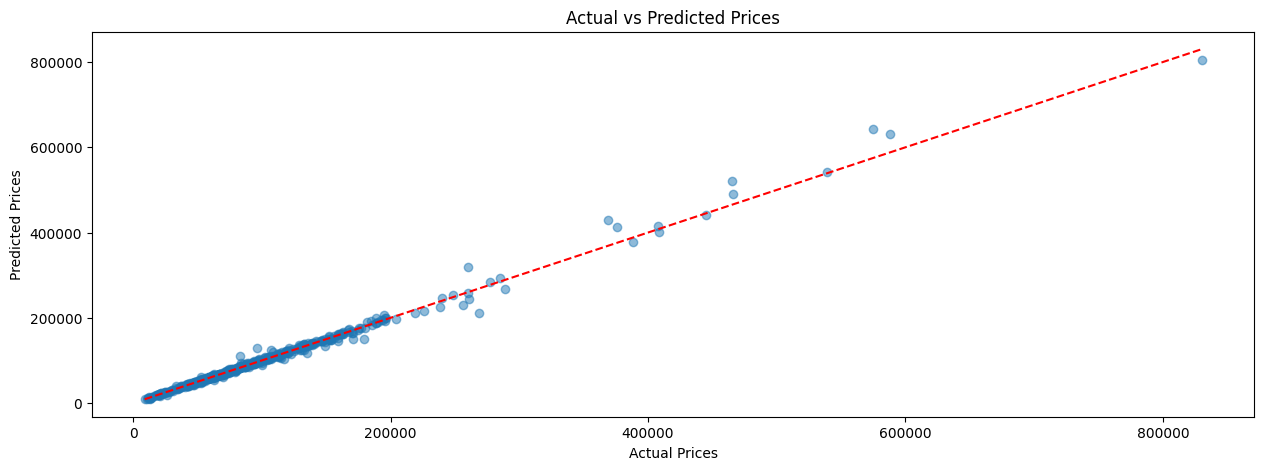

In [11]:
# Create a figure with a specific size (15 inches wide, 5 inches tall)
plt.figure(figsize=(15, 5))

# Scatter plot of actual vs predicted values
# - y_test: Actual target values from the test set
# - y_pred: Predicted target values from the model
# - alpha=0.5: Makes the points semi-transparent to better visualize density
plt.scatter(y_test, y_pred, alpha=0.5)

# Plot a diagonal red dashed line representing perfect predictions
# - [y_test.min(), y_test.max()]: X-axis range (actual values)
# - [y_test.min(), y_test.max()]: Y-axis range (predicted values)
# - color='red': Line color is red
# - linestyle='--': Line style is dashed
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

# Configure the plot
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')

# Display the plot
plt.show()


### 📊 **Errors Distribution**
- Plot the residuals (errors) as the difference between the actual and predicted values (y_test - y_pred).
- This helps you see if the errors are randomly distributed or if there’s a pattern (e.g., heteroscedasticity).

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Predicted Values')

Text(0, 0.5, 'Residuals')

Text(0.5, 1.0, 'Residual Plot')

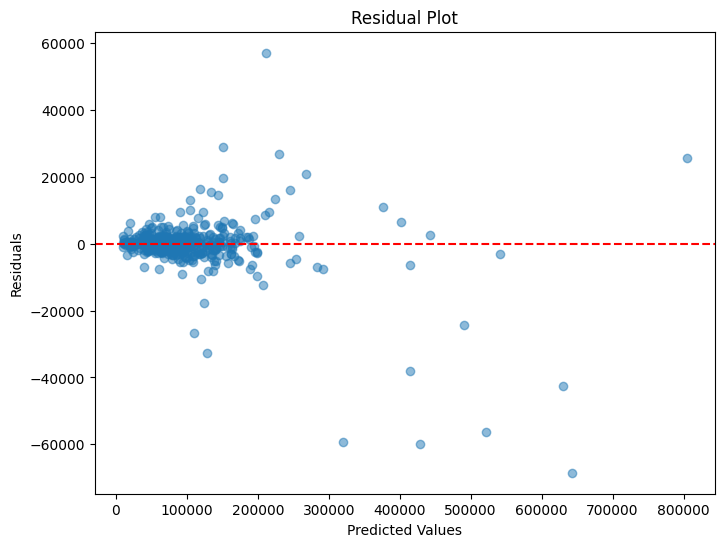

(array([  1.,   0.,   3.,   0.,   0.,   0.,   1.,   1.,   1.,   1.,   1.,
          0.,   1.,   2.,  13., 100., 309.,  43.,  10.,   3.,   3.,   2.,
          2.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-68478.875    , -64293.3515625, -60107.828125 , -55922.3046875,
        -51736.78125  , -47551.2578125, -43365.734375 , -39180.2109375,
        -34994.6875   , -30809.1640625, -26623.640625 , -22438.1171875,
        -18252.59375  , -14067.0703125,  -9881.546875 ,  -5696.0234375,
         -1510.5      ,   2675.0234375,   6860.546875 ,  11046.0703125,
         15231.59375  ,  19417.1171875,  23602.640625 ,  27788.1640625,
         31973.6875   ,  36159.2109375,  40344.734375 ,  44530.2578125,
         48715.78125  ,  52901.3046875,  57086.828125 ]),
 <BarContainer object of 30 artists>)

Text(0.5, 0, 'Residuals')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Residual Distribution')

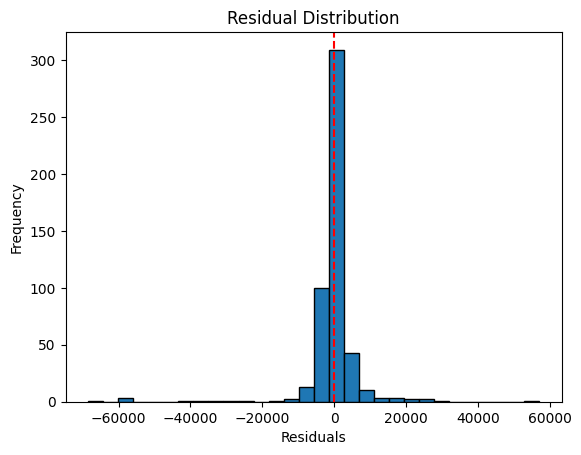

In [12]:
residuals = y_test - y_pred

# Plot residuals vs. predicted values to check for patterns
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test - y_pred, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')  # Line at zero residual
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# Plot histogram of residuals to assess normality
plt.hist(y_test - y_pred, bins=30, edgecolor='black')
plt.axvline(0, color='red', linestyle='--')  # Line at zero
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()


### 📊 **MSE, RMSE and Relative Errors**
- `MSE (Mean Squared Error)`
    - Average of squared differences between actual (y_test) and predicted (y_pred) values.
    - Penalizes large errors more but is not in the same units as the target variable.
- `RMSE (Root Mean Squared Error)`
    - Square root of MSE, expressed in the same units as the target variable for easier interpretation.
    - Indicates the average magnitude of prediction errors.
- `RMSE as a Percentage of Range`
    - Range: Difference between the maximum and minimum values of y_test.
    - RMSE as a percentage of the range shows error size relative to the variability of the target variable.
- `RMSE as a Percentage of Mean`
    - Mean: Average value of y_test, serving as a reference for typical values.
    - RMSE as a percentage of the mean highlights error magnitude relative to the average target value.

In [13]:
# Calculate Mean Squared Error (MSE)
# MSE measures the average squared prediction error.
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
# RMSE is the square root of MSE, making it interpretable in the target variable's units.
rmse = np.sqrt(mse)

# Calculate the range of the target variable (y_test)
# Range indicates the spread of the target variable.
range_y_test = y_test.max() - y_test.min()

# Calculate the mean of the target variable (y_test)
# Mean provides a reference for typical values in the target variable.
mean_y_test = y_test.mean()

# Calculate RMSE as a percentage of the range
# This provides a relative measure of error compared to the target variable's variability.
rmse_range_pct = (rmse / range_y_test) * 100

# Calculate RMSE as a percentage of the mean
# This highlights the error magnitude relative to the average target value.
rmse_mean_pct = (rmse / mean_y_test) * 100

# Print Results
print("📊 **Error Metrics**")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Range of y_test: {range_y_test:.2f}")
print(f"Mean of y_test: {mean_y_test:.2f}")
print(f"RMSE as a percentage of range: {rmse_range_pct:.2f}%")
print(f"RMSE as a percentage of mean: {rmse_mean_pct:.2f}%")


📊 **Error Metrics**
Mean Squared Error (MSE): 65184978.32
Root Mean Squared Error (RMSE): 8073.72
Range of y_test: 821000.00
Mean of y_test: 98857.37
RMSE as a percentage of range: 0.98%
RMSE as a percentage of mean: 8.17%


### 📊 **MAE and MAPE**
- `MAE (Mean Absolute Error)`
    - The average of the absolute differences between actual (y_test) and predicted (y_pred) values.
    - Measures the magnitude of errors without considering direction, making it intuitive and less sensitive to outliers compared to MSE.
    - Expressed in the same units as the target variable, making it easy to interpret.
- `MAPE (Mean Absolute Percentage Error)`
    - The average of absolute percentage errors, expressed as a percentage of actual values.
    - Useful for understanding error size relative to the scale of the target variable.
    - Example: A MAPE of 5% means predictions are, on average, 5% off from actual values.
    - Note: Can be sensitive to very small actual values, leading to inflated errors.

In [14]:
# Calculate Mean Absolute Error (MAE)
# MAE is the average of the absolute differences between actual (y_test) and predicted (y_pred) values.
mae = mean_absolute_error(y_test, y_pred)

# Calculate Mean Absolute Percentage Error (MAPE)
# MAPE is the average of absolute percentage errors, expressed as a percentage of actual values.
# Avoid division by zero by replacing zeros in y_test with a small constant.
epsilon = 1e-10  # Small constant to avoid division by zero
mape = np.mean(np.abs((y_test - y_pred) / (y_test + epsilon))) * 100

# Print the results
print("📊 **Error Metrics**")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


📊 **Error Metrics**
Mean Absolute Error (MAE): 3323.49
Mean Absolute Percentage Error (MAPE): 3.09%


### 📊 **R-squared (R²) and Adjusted R²**
- `R-squared (R²)`
    - Definition: R² measures the proportion of the variance in the target variable (y_test) that is explained by the model's predictions.
    - Interpretation:
        - R² ranges from 0 to 1, where:
            - 0 indicates that the model does not explain any variance in the target variable.
            - 1 indicates that the model explains all the variance, i.e., perfect predictions.
        - Higher R² values indicate that the model is a better fit for the data, capturing the relationships between features and the target variable.
    - Example: An R² of 0.85 means that 85% of the variance in the target variable is explained by the model.
    - Limitation: R² can be misleading if used alone, especially when comparing models with different numbers of features. It's important to complement it with other metrics like RMSE or MAE for a comprehensive evaluation.
- `Adjusted R-squared (Adjusted R²)`
    - Definition: Adjusted R² adjusts the R² value to account for the number of predictors (features) in the model, providing a more accurate measure of model fit when comparing models with different numbers of predictors.
    - Interpretation:
        - Unlike R², which can increase as more predictors are added to the model, Adjusted R² penalizes the inclusion of irrelevant features.
        - It adjusts the R² value based on the number of data points (n) and the number of features (p), helping to prevent overfitting.
        - Higher values indicate a better model fit, while negative values suggest a poor model.
    - Example: If R² is 0.85 but Adjusted R² is 0.80, the model is still a good fit, but the lower adjusted value suggests that some features may not be contributing significantly to the model’s explanatory power.
    - Limitation: Adjusted R² is useful for comparing models with different numbers of predictors but still does not account for overfitting in all cases. It should be used alongside other evaluation metrics for a full assessment.

In [15]:
# Calculate R-squared (R²)
# R² measures the proportion of variance in the target variable that is explained by the model.
r2 = r2_score(y_test, y_pred)

# Calculate Adjusted R-squared (R²_adj)
# Adjusted R² accounts for the number of predictors in the model, adjusting for overfitting.
n = len(y_test)  # Number of data points
p = X_test.shape[1]  # Number of features (predictors)
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Print the results
print("📊 **Error Metrics**")
print(f"R-squared (R²): {r2:.2f}")
print(f"Adjusted R-squared (R²_adj): {adj_r2:.2f}")


📊 **Error Metrics**
R-squared (R²): 0.99
Adjusted R-squared (R²_adj): 0.99


## 📬 **Save Model**

In [16]:
# Save the model
joblib.dump(model_pipeline, '../models/model.pkl')


['../models/model.pkl']

# ----------------------------------- END -----------------------------------